# <center>Welcome FSP solved with diverse heuristics</center>

This notebook presents a practical approach to solving the flowshop problem by implementing well-known heuristics. These heuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources.

You can visit the website to test the implemented heuristics and gain a comparative insight :  https://flow-shop-problem.streamlit.app

# Table of Contents

1. [Johnson **n** jobs **2** machines](#Johnson-**n**-jobs-**2**-machines)
2. [CDS Heuristic](#cds-heuristic)
3. [NEH Heuristic](#neh-heuristic)
4. [Ham Heuristic](#ham-heuristic)
5. [Palmer Heuristic](#palmer-heuristic)
6. [PRSKE Heuristic](#prske-heuristic)
8. [Chen Heuristic](#Chen-heuristic-(1983))
7. [Weighted CDS Heuristic](#Weighted-CDS-heuristic)
9. [Gupta Heuristic](#gupta-heuristic)
10. [NRH Heuristic (NEW Ramzi Heuristic)](#nrh-heuristic-new-ramzi-heuristic)
11. [Kusiak Heuristic ](#Kusiak-heuristic)
12. [ Comparison Figure   ](#Comparison-Figure)




## Data Utils

In [1]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from utils.benchmarks import benchmarks, upper_bound

### Path Cost calculation function :
used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [2]:
def incremental_cost(machine_job_matrix, jobs_sequence):
    nb_jobs = len(jobs_sequence)
    nb_machines = machine_job_matrix.shape[0]

    incremental_cost = np.zeros((nb_machines, nb_jobs))

    # evaluate the first machines
    incremental_cost[0, 0] = machine_job_matrix[0][jobs_sequence[0]]

    for i in range(1, nb_jobs):
        incremental_cost[0][i] = incremental_cost[0][i - 1] + \
            machine_job_matrix[0][jobs_sequence[i]]

    # evaluate the rest of machines
    for i in range(1, nb_machines):
        incremental_cost[i, 0] = incremental_cost[i - 1, 0] + \
            machine_job_matrix[i, jobs_sequence[0]]
        for j in range(1, nb_jobs):
            incremental_cost[i, j] = machine_job_matrix[i, jobs_sequence[j]] + \
                max(incremental_cost[i - 1, j], incremental_cost[i, j - 1])
    return incremental_cost[-1,-1]

### Gantt graph generator

In [3]:
def generate_gantt_chart(current_instance, solution):
    plt.figure(figsize=(20, 12))
    df = pd.DataFrame(columns=['Machine', 'Job', 'Start', 'Finish'])

    machines, jobs = current_instance.shape
    machine_times = np.zeros((machines, jobs))
    start_time_m = np.zeros(machines)
    for job in solution:

        for machine_index in range(machines):
            start_time = start_time_m[machine_index]
            if machine_index > 0:
                start_time = max(start_time, start_time_m[machine_index-1])
            end_time = start_time + \
                current_instance[machine_index, job]
            start_time_m[machine_index] = end_time

            df = pd.concat([df, pd.DataFrame({'Machine': f'Machine {machine_index + 1}',
                                                'Job': f'Job {job + 1}',
                                                'Start': start_time,
                                                'Finish': end_time}, index=[0])], ignore_index=True)

            machine_times[machine_index, job] = end_time

    colors = plt.cm.tab10.colors
    for i, machine_index in enumerate(range(machines)):
        machine_df = df[df['Machine'] == f'Machine {machine_index + 1}']
        plt.broken_barh([(start, end - start) for start, end in zip(machine_df['Start'], machine_df['Finish'])],
                        (i * 10, 9), facecolors=[colors[j % 10] for j in range(jobs)], edgecolor='black')

    plt.xlabel('Time')
    plt.yticks([i * 10 + 4.5 for i in range(machines)],
                [f'Machine {i + 1}' for i in range(machines)])
    plt.show()

# Heuristics

## Johnson **n** jobs **2** machines

In [4]:
def johnson_method(processing_times):
    jobs, machines = processing_times.shape
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        
    return m1+m2

### Test Johnson

In [5]:
# Generate a random example to work with 7 jobs and 2 machines
rnd_data = np.random.randint(size=(7,2), low=5, high=23)
print(rnd_data, "\n")

start_time = time.time()
sol = johnson_method(rnd_data)
elapsed_time = time.time() - start_time

print(f'Best sequence found by Johnson is {sol} with a makespan of {incremental_cost(np.array(rnd_data).T,sol)}')
print("Elapsed time:", elapsed_time, "seconds")

[[14 22]
 [18  9]
 [ 5  7]
 [ 6 13]
 [10 14]
 [21  5]
 [10 11]] 

Best sequence found by Johnson is [2, 3, 4, 6, 0, 1, 5] with a makespan of 89.0
Elapsed time: 0.0012578964233398438 seconds


## CDS Heuristic

### CDS Heuristic [Campbell,Dudek and Smith ] : **n** jobs **m** machines (1970)

In [6]:
# python code for CDS heuristic

def cds_heuristic(processing_times):
    
    
    nb_machines, nb_jobs = processing_times.shape


    best_cost = math.inf

    
    machine_1_times = np.zeros((nb_jobs,1))
    machine_2_times = np.zeros((nb_jobs,1))
    
    
    # iterate through the nb_machines-1 auxiliary n-job 2-machines problems



    for k in range(nb_machines -1):
        machine_1_times[:,0] += processing_times[:][k]
        machine_2_times[:,0] += processing_times[:][-k-1]
        
        jn_times = np.concatenate((machine_1_times, machine_2_times), axis=1)
        seq = johnson_method(jn_times)
        cost = incremental_cost(jn_times.T,seq)
        if cost < best_cost:
            best_cost = cost
            best_seq = seq

    makespan = incremental_cost(processing_times, best_seq)

    return best_seq, makespan


### Test CDS

In [7]:
rnd_data = np.random.randint(size=(8,5), low=10, high=50)
print(rnd_data, "\n")
cds_heuristic(rnd_data.T)

[[46 39 22 35 13]
 [39 40 38 30 48]
 [31 18 13 11 17]
 [38 39 42 30 18]
 [19 44 26 22 11]
 [11 27 43 28 27]
 [17 48 42 19 43]
 [47 24 41 16 23]] 



([5, 6, 1, 7, 3, 2, 0, 4], 371.0)

In [8]:
start_time = time.time()
best_solution, best_cost  = cds_heuristic(benchmarks[0].T)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of CDS:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of CDS:
Best sequence is [14, 2, 8, 13, 16, 7, 6, 0, 18, 3, 10, 15, 11, 1, 4, 5, 19, 17, 9, 12] with a makespan of 1390.0.
Elapsed time of 0.008341550827026367 seconds.


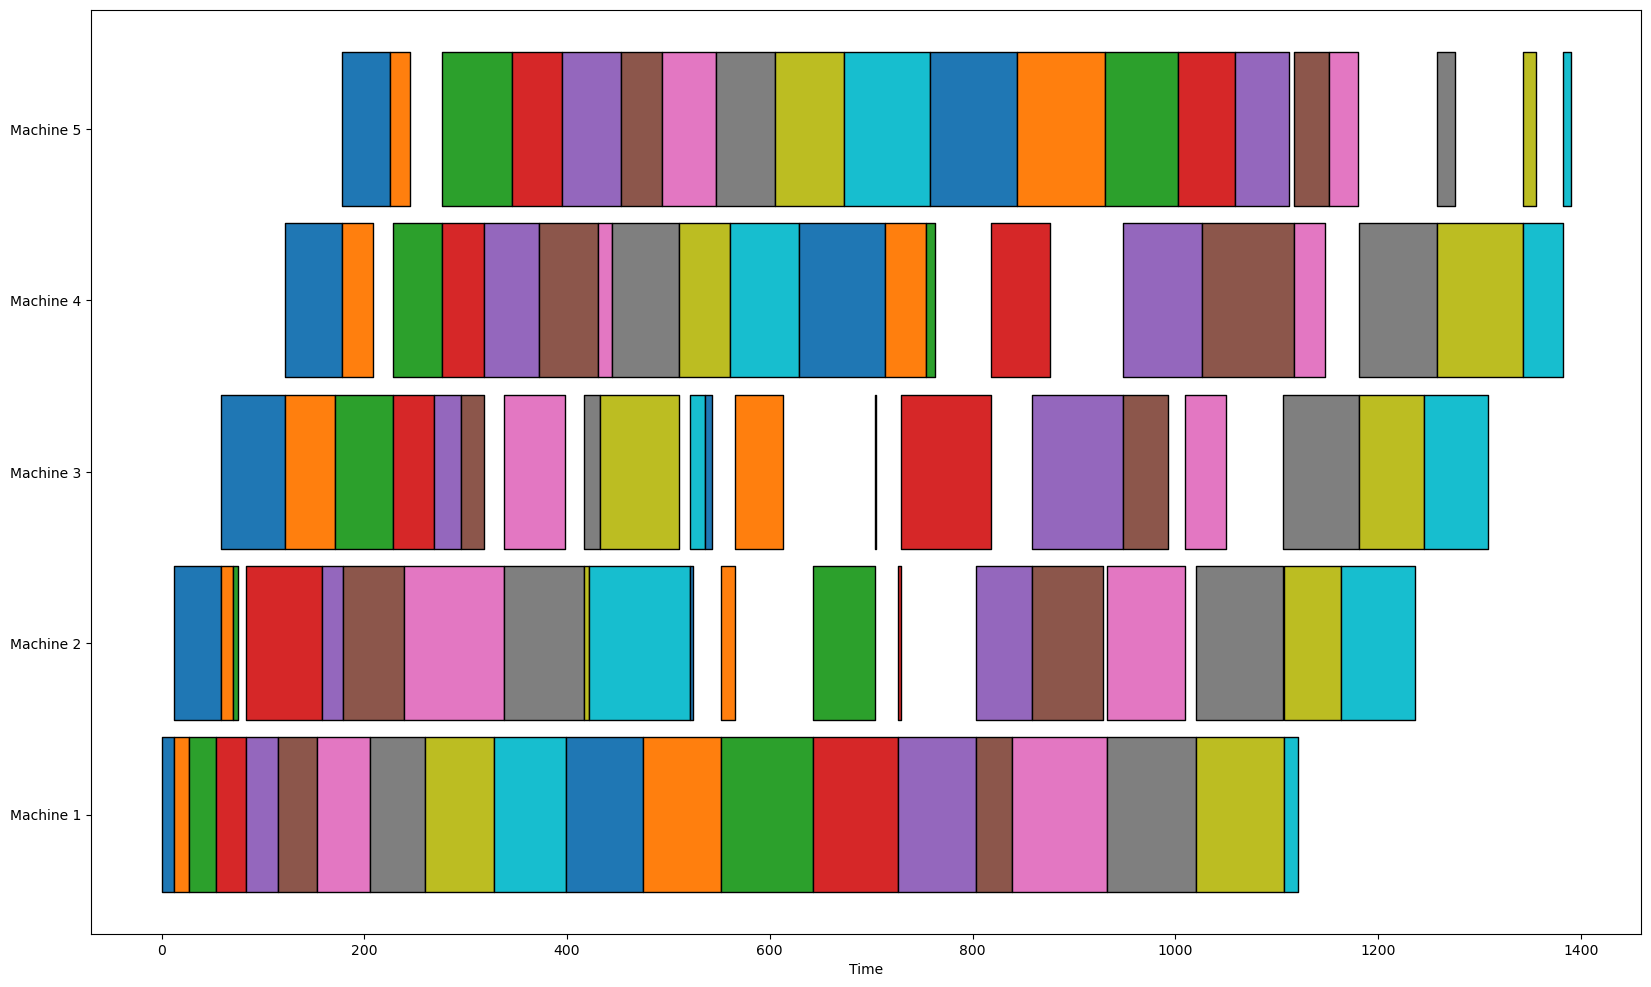

In [9]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## NEH Heuristic

In [10]:
def order_jobs_in_descending_order_of_total_completion_time(processing_times):
    total_completion_time = processing_times.sum(axis=1)
    return np.argsort(total_completion_time, axis=0).tolist()

In [11]:
def insertion(sequence, position, value):
    new_seq = sequence[:]
    new_seq.insert(position, value)
    return new_seq

In [12]:
def neh_algorithm(processing_times):
    ordered_sequence = order_jobs_in_descending_order_of_total_completion_time(processing_times)
    # Define the initial order
    J1, J2 = ordered_sequence[:2]
    sequence = [J1, J2] if incremental_cost(processing_times.T,[J1, J2]) < incremental_cost(processing_times.T,[J2, J1]) else [J2, J1]
    del ordered_sequence[:2]
    # Add remaining jobs
    for job in ordered_sequence:
        Cmax = float('inf')
        best_sequence = []
        for i in range(len(sequence)+1):
            new_sequence = insertion(sequence, i, job)
            Cmax_eval = incremental_cost(processing_times.T,new_sequence)
            if Cmax_eval < Cmax:
                Cmax = Cmax_eval
                best_sequence = new_sequence
        sequence = best_sequence
    return sequence, Cmax

In [13]:
start_time = time.time()
best_solution,best_cost  = neh_algorithm(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of NEH:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')


Results of NEH:
Best sequence is [8, 6, 15, 10, 7, 1, 16, 2, 14, 13, 17, 3, 9, 11, 0, 18, 5, 4, 12, 19] with a makespan of 1334.0.
Elapsed time of 0.061142921447753906 seconds.


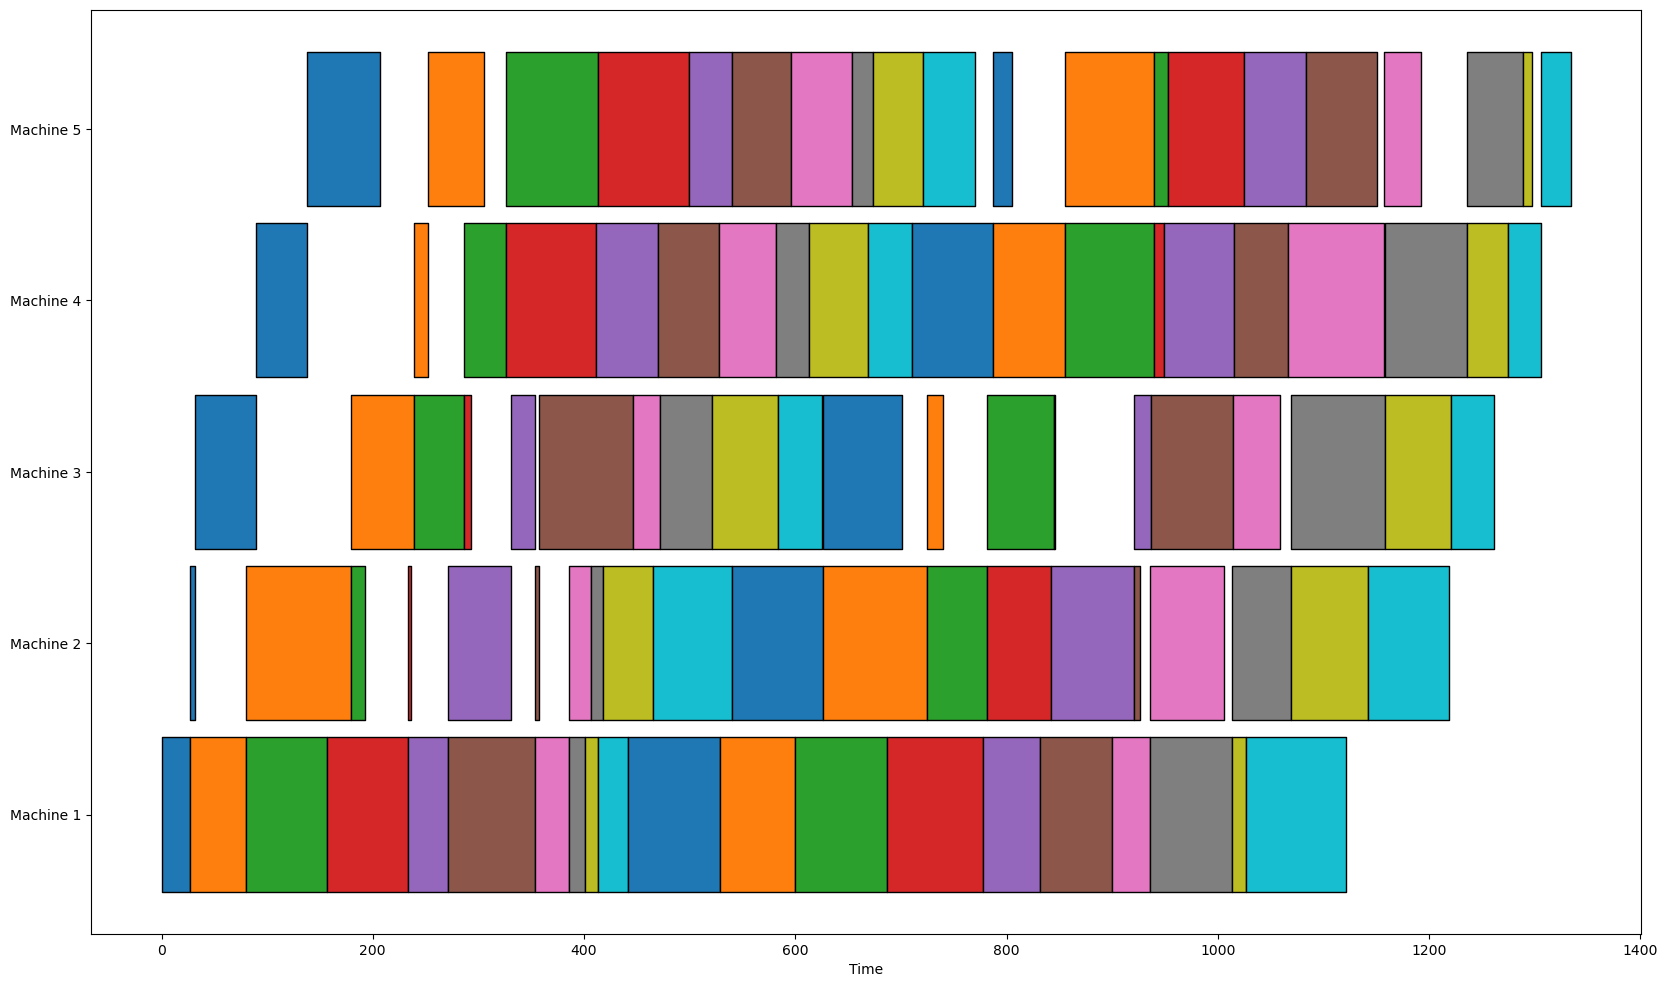

In [14]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Ham Heuristic

In [15]:
def indices_from_list_values(master: np.ndarray, values: list) -> list:
    indexes = []
    for element in values:
        for i in range(master.size):
            if master[i] == element and i not in indexes:
                indexes.append(i)
                continue
    return indexes

In [16]:
def ham_sol_1(Pi1: np.ndarray, Pi2: np.ndarray) -> list:
    diff = Pi2 - Pi1
    sol = np.argsort(diff, axis=0).tolist()
    sol.reverse()       # in decreasing order
    return sol

In [17]:
def ham_sol_2(Pi1: np.ndarray, Pi2: np.ndarray) -> list:

    diff = Pi2 - Pi1
    according_pi1 = np.argwhere(diff >= 0)
    according_pi2 = np.argwhere(diff < 0)

    # Order Pi1 in increasing order
    Pi1_sorted= np.sort(Pi1[according_pi1], axis=None).tolist()
    Pi1_list = indices_from_list_values(Pi1, Pi1_sorted)

    # Order Pi2 in decreasing order
    Pi2_sorted = np.sort(Pi2[according_pi2], axis=None).tolist()
    Pi2_sorted.reverse()
    Pi2_list = indices_from_list_values(Pi2, Pi2_sorted)

    return Pi1_list + Pi2_list

In [18]:
def ham_heuristic(processing_times: np.ndarray) -> list:
    _ , m = processing_times.shape
    left = processing_times[:, :int(m/2)]
    right = processing_times[:, int(m/2):]

    Pi1 = left.sum(axis=1)
    Pi2 = right.sum(axis=1)

    solution1 = ham_sol_1(Pi1, Pi2)
    solution2 = ham_sol_2(Pi1, Pi2)
    Cmax1 = incremental_cost(processing_times.T, solution1)
    Cmax2 = incremental_cost(processing_times.T, solution2)
    
    if Cmax1 < Cmax2:
        return solution1, Cmax1
    else:
        return solution2, Cmax2

### TEST HAM

In [19]:
start_time = time.time()
best_solution, best_cost  = ham_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of HAM:')
print(f'Best sequence is {best_solution} with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of HAM:
Best sequence is [2, 8, 16, 14, 18, 10, 1, 12, 15, 7, 13, 5, 0, 4, 9, 17, 3, 6, 19, 11] with a makespan of 1417.0.
Elapsed time of 0.0 seconds.


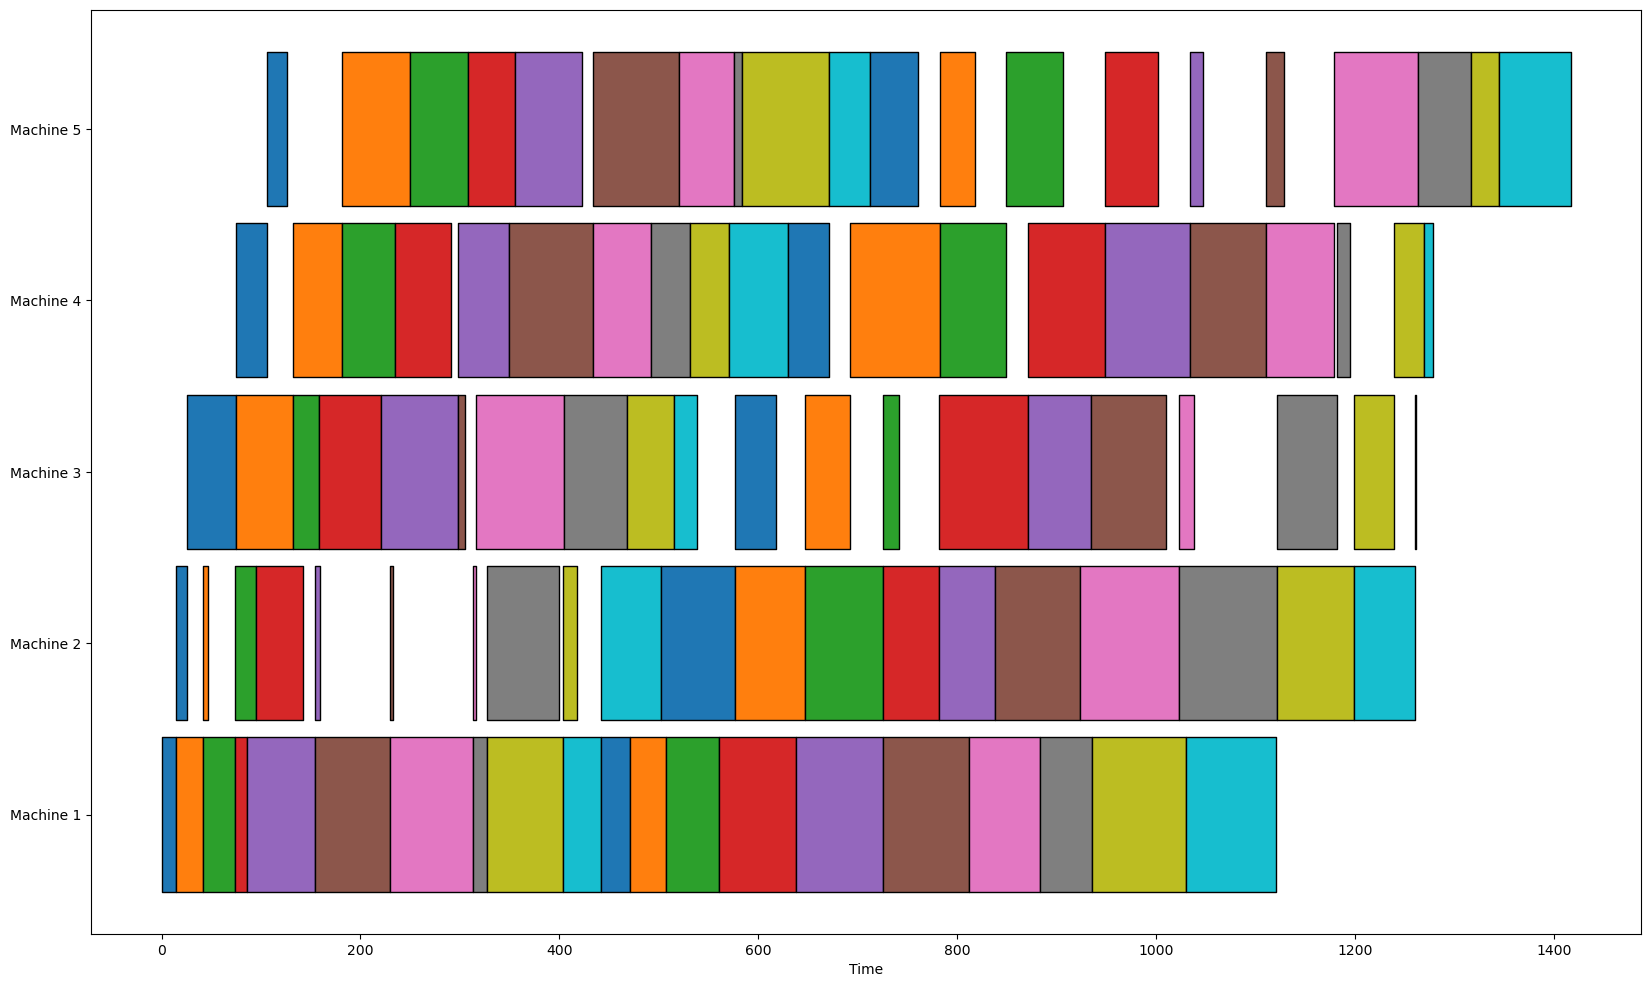

In [20]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Palmer Heuristic

In [21]:
class PalmerHeuristic:
    def __init__(self, dist_mat):
        self.dist_mat = dist_mat
        self.c = None
        self.ordre_opt = []
        self.nb_machines = dist_mat.shape[0]
        self.nb_jobs = dist_mat.shape[1]
        self.weights = None
 

    def init_weights(self):      #middle machine has a weight of 0 and it increases/decreases toward last/first machine at same rate (Example for 3 machines: the weights are w1 =-2 w2 =0 w3 =+2)
        lst = np.array([ (2*i - 1 - self.nb_machines) for i in range(self.nb_machines)])
        return lst - np.mean(lst)
   

    def compute_weighted_sum(self):       #Computing weighted sum for each job (Example for j1: w1*d11 + w2*d12 + w3*d13)
        weighted_sum = []
        for i in range(self.nb_jobs):
            somme = np.dot(self.dist_mat[:,i],self.weights)
            weighted_sum.append(somme)
        return np.array(weighted_sum)
   

    def sum_per_machine(self):      #Find the sum of time of each machine
        return self.dist_mat.sum(axis=1)
                                 
    
    def update_c(self, c, ordre):         # Update the computation time to get the makespan
        c[0][0] = self.dist_mat[0,ordre[0]]
        for j in range(1,self.nb_machines):
            c[0][j] = self.dist_mat[j,ordre[0]] + c[0][j-1]
        for j in range (1, self.nb_jobs):
            c[j][0] = self.dist_mat[0, ordre[j]] + c[j-1][0]
        for i in range(1, self.nb_jobs):
            for j in range(1,self.nb_machines):
                c[i][j] = max([c[i-1][j],c[i][j-1]]) + self.dist_mat[j,ordre[i]]
        return c 

    
    def get_cmax(self):               # Cmax : makespan
        return self.c[len(self.ordre_opt)-1][self.dist_mat.shape[0]-1]
    
    
    def lower_bound(self):                     #Define the lower bound (upperbound is the cmax found)
        lb = []
        for i in range(self.nb_machines):
            a = self.sum_per_machine()
            if i == 0:
                bound = a[i] + min(self.dist_mat.T[:,1:].sum(axis=1))
            
            elif i == (self.nb_machines -1) :
                bound = a[i] + min(self.dist_mat.T[:,:i].sum(axis=1)) 
            
            else :
                bound = a[i] + min(self.dist_mat.T[:,:i].sum(axis=1)) + min(self.dist_mat.T[:,i+1])
            
            lb.append(bound)
        return max(lb)
    

    def run(self):
        self.weights = self.init_weights()
        C = np.zeros((self.nb_jobs, self.nb_machines))
        
        self.c = C
        a = self.compute_weighted_sum()
        self.ordre_opt = np.argsort(a)[::-1] #argsort effectue le tri dans l'ordre ascendant donc on l'inverse
    
        self.update_c(self.c,self.ordre_opt)
        lb = self.lower_bound()
        # print('optimal order for Palmer')
        # print(self.ordre_opt)
        # print('\nCmax: ' + str(self.get_cmax()))
        # print('Lower Bound: ' + str(lb))
        # print(self.c)     

        return  self.ordre_opt , self.get_cmax()

### PALMER Test

In [22]:
start_time = time.time()
a = PalmerHeuristic(benchmarks[0].T)
result, makespan = a.run()

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of Palmer:')
print(f'Best sequence is {result} \nwith a makespan of {makespan}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Palmer:
Best sequence is [ 8 10 16 14 15 18  2  5 13  7  1  3  0  4 12  6 11  9 17 19] 
with a makespan of 1384.0.
Elapsed time of 0.005047798156738281 seconds.


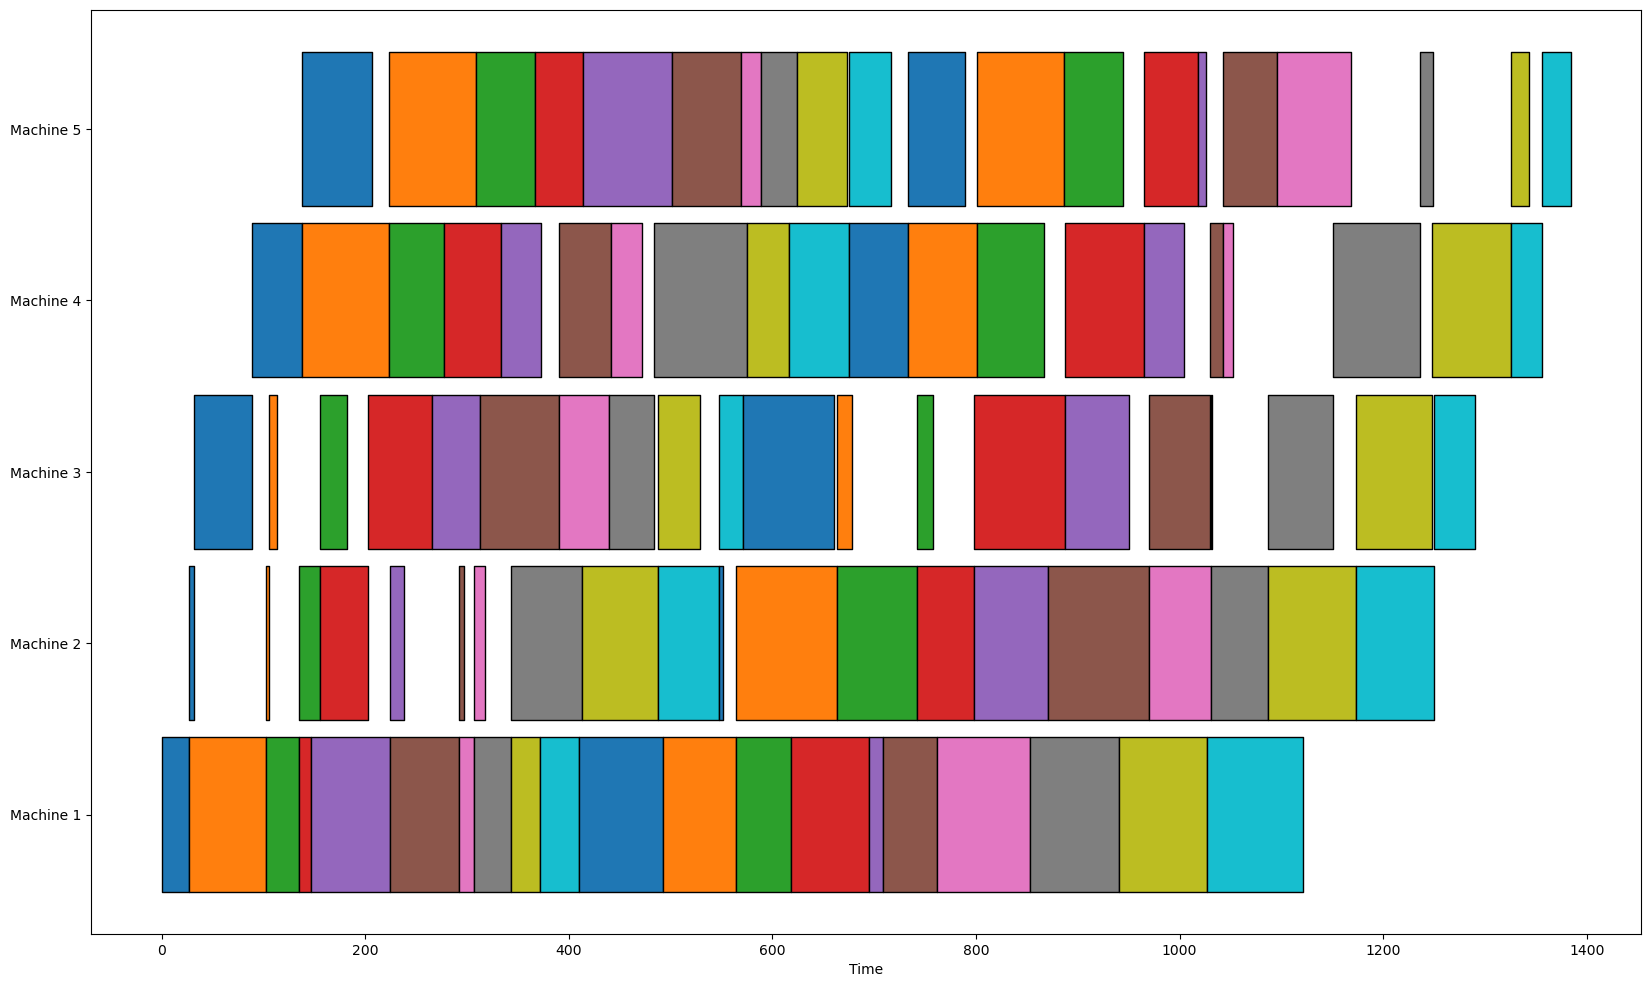

In [23]:
generate_gantt_chart(benchmarks[0].T, result)

## PRSKE Heuristic

In the new PRSKE priority rule, all jobs are ordered by the non-increasing sum of : $$ AVG_i + STD_i + |SKE_i|$$ 
where:

- $ AVG_i $ represents the average processing time of job _i_.
- $ STD_i $ stands for the standard deviation of job _i_.
- $ |SKE_i| $ denotes the absolute value of the skewness of job _i_.

The parameters are defined as follows:

- $$ AVG_i = \frac{1}{m} \sum_{k=1}^{m} t_{i,k}$$
- $$ STD_i = \sqrt{\frac{1}{m-1} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^2} $$
- $$ SKE_i = \frac{\frac{1}{m} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^3}{\left({\sqrt{\frac{1}{m} \sum_{k=1}^{m} (t_{i,k} - AVG_i)^2}}\right)^3} $$

where:

- $ t_{i,k} $ represents the processing time of job _i_ on machine _k_.
- $ m $ is the number of machines.



In [24]:
def AVG(processing_times):
    return np.mean(processing_times, axis=1)

In [25]:
def STD(processing_times):
    return np.std(processing_times, axis=1, ddof=1)

In [26]:
def skewness_SKE(processing_times):
    """
    Calculates the skewness of job processing times across machines.
    Return : Skewness values for each job
    
    """
    num_jobs, num_machines = processing_times.shape
    skewness_values = []

    
    for i in range(num_jobs):
        avg_processing_time = np.mean(processing_times[i,:])
        numerateur = 0
        denominateur = 0

        for j in range(num_machines):
            som = (processing_times[i,j] - avg_processing_time)
            numerateur += som ** 3
            denominateur += som ** 2

        numerateur *= (1 / num_machines)
        denominateur = (np.sqrt(denominateur * (1 / num_machines))) ** 3

        skewness_values.append(numerateur / denominateur)
        
    return np.array(skewness_values)

In [27]:
def PRSKE(processing_times):
    """
    Calculates the job sequence based on the PRSKE priority rule

    """
    avg = AVG(processing_times)   # Calculate average processing times

    std = STD(processing_times)   #Calculate standard deviation processing times

    skw = np.abs(skewness_SKE(processing_times)) # Calculate Skewness 

    order = skw + std + avg  

    # Sort in descending order
    sorted_order = sorted(zip(order, list(range(processing_times.shape[0]))),reverse=True)

    sequence = [job for _ , job in sorted_order]

    incremental_cost_value = incremental_cost(processing_times.T, sequence)  # Calculte incremental_cost

    return sequence,  incremental_cost_value 

### TEST PRSKE

In [28]:
start_time = time.time()
best_solution, best_cost  = PRSKE(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of PRSKE:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of PRSKE:
Best sequence is [3, 17, 10, 1, 9, 11, 4, 6, 19, 18, 15, 5, 0, 12, 8, 14, 13, 7, 16, 2] 
 with a makespan of 1593.0.
Elapsed time of 0.004014015197753906 seconds.


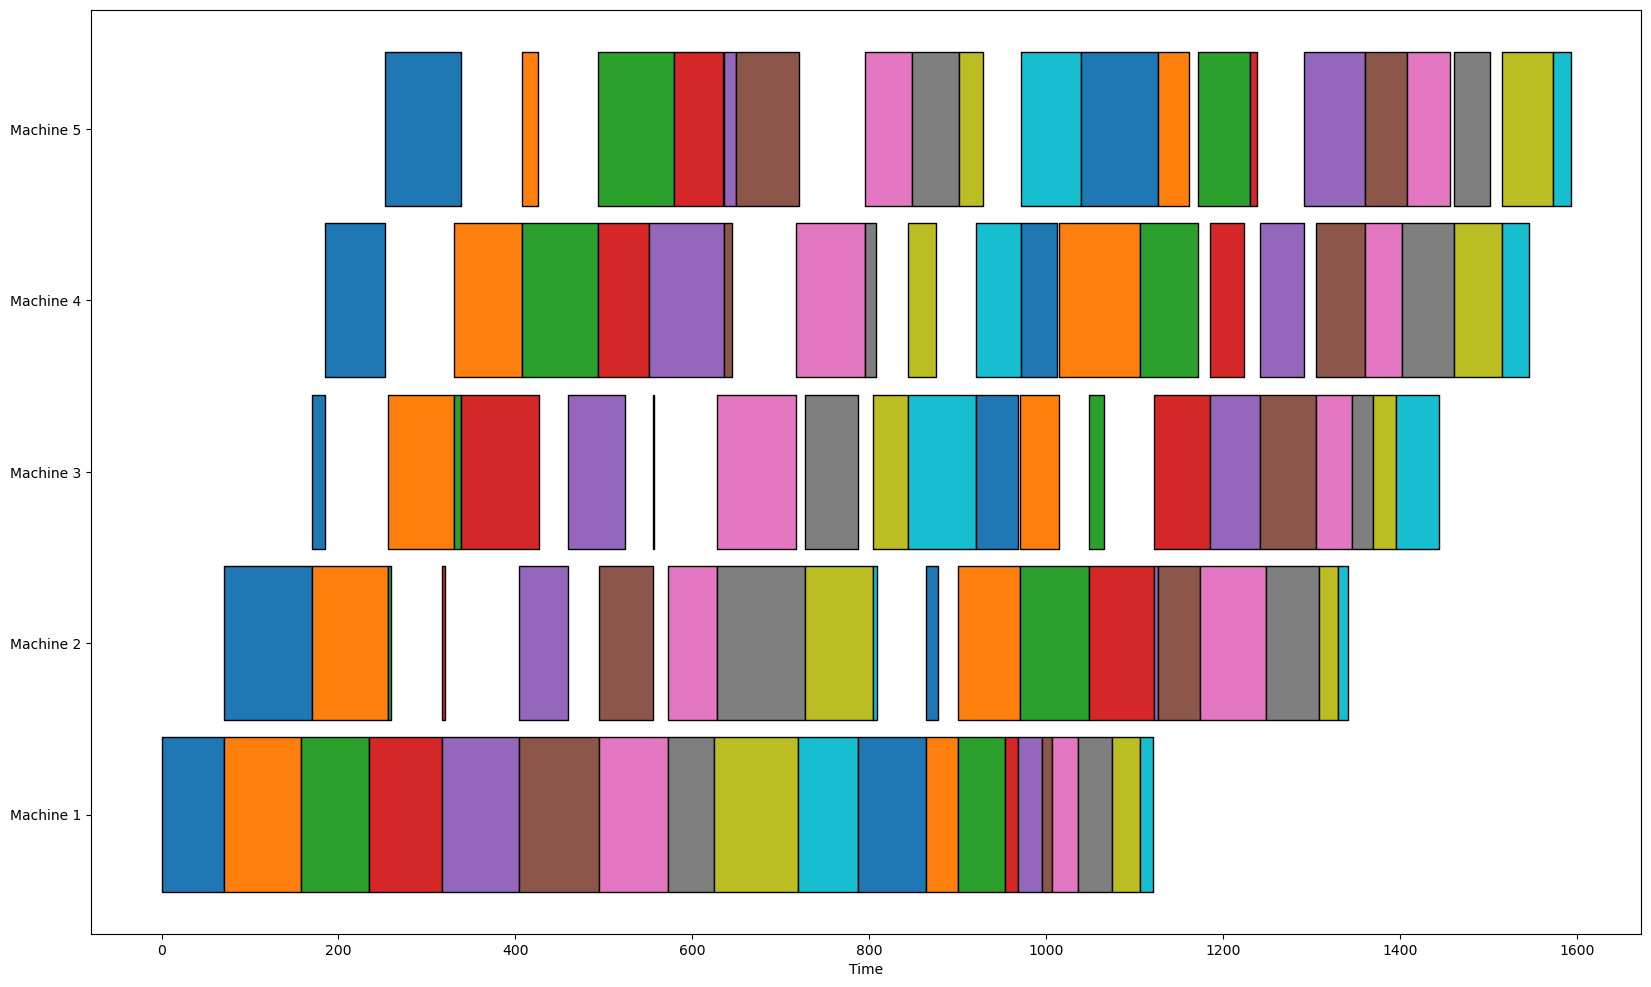

In [29]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## CHEN Heuristic (1983)

Chen (1983) propose une heuristique qui consiste à procéder de la manière suivante :

- on calcule la somme de temps opératoires $ S(i) $  pour chaque tâche i avec :
$$ S(i) = \sum_{k=1}^{m} t_{i,k} $$
- on trouve la tâche c qui a la $ S(i) $ la plus importante et on enlève cette tâche de l'ensemble de tâches non ordonnancées.
- on ordonnance les tâches qui ont $ P_{i1} <= P_{im} $ dans l'ordre croissant de $ P_{i1} $ et on obtient un ordonnancement partiel $ SA $.
- on ordonnance les tâches qui ont $ P_{i1}>P_{im} $ dans l'ordre décroissant de $ P_{im} $ et on obtient un ordonnancement partiel $ SB $ .
- on retient comme solution finale l'ordonnancement $ (SA, c, SB) $

In [30]:
def chen_heuristic(processing_times):

    num_jobs = len(processing_times)
    
    sum_processing_times = [sum(processing_times[i]) for i in range(num_jobs)] # Calcule de la somme de temps opératoires S(i) pour chaque tâche i

    job_max_sum = max(sum_processing_times)
    job_c = sum_processing_times.index(job_max_sum)
    
    remaining_jobs = [i for i in range(num_jobs) if i != job_c]
    
    sorted_jobs_le = sorted(remaining_jobs, key=lambda i: processing_times[i][0])
    
    sorted_jobs_gt = sorted(remaining_jobs, key=lambda i: processing_times[i][-1], reverse=True)
   
    S_a = [i for i in sorted_jobs_le if processing_times[i][0] <= processing_times[i][-1]]
    S_b = [i for i in sorted_jobs_gt if processing_times[i][0] > processing_times[i][-1]]
    
    sequence = S_a + [job_c] + S_b
    
    incremental_cost_value = incremental_cost(processing_times.T, sequence)
    
    return sequence, incremental_cost_value

### Test Chen heuristic

In [31]:
start_time = time.time()

best_solution, best_cost  = chen_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of CHEN:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of CHEN:
Best sequence is [14, 2, 8, 13, 16, 7, 6, 0, 18, 3, 10, 15, 4, 11, 1, 5, 19, 17, 9, 12] 
 with a makespan of 1390.0.
Elapsed time of 0.0 seconds.


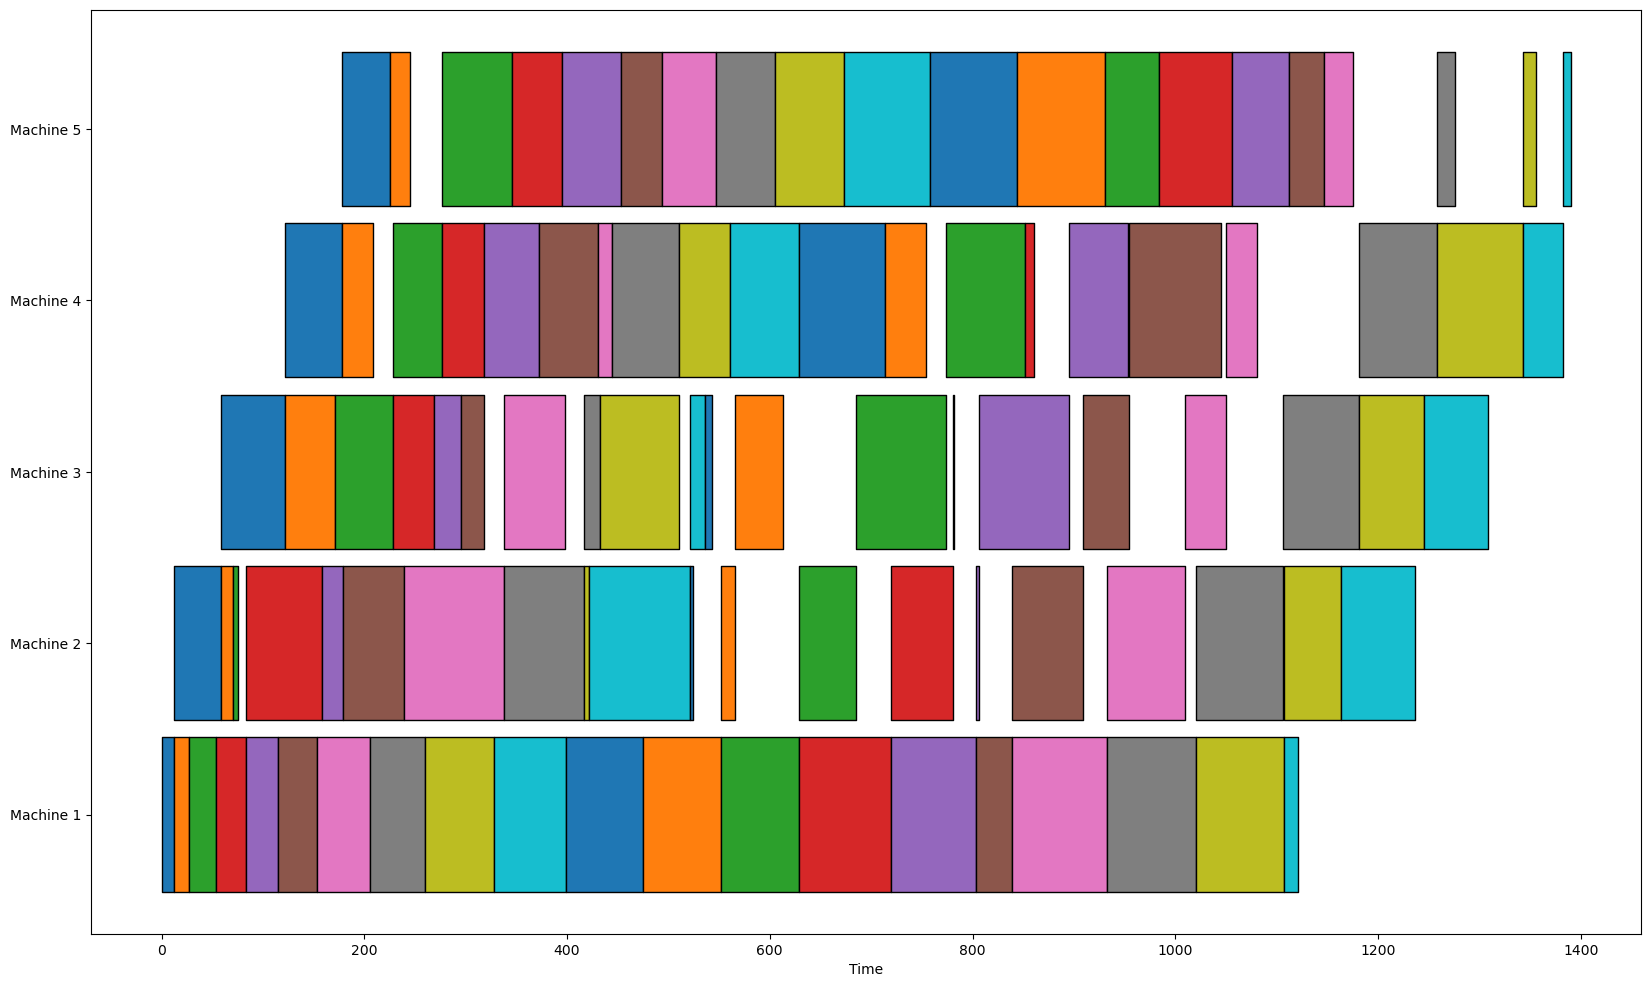

In [32]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Weighted CDS Heuristic

In [33]:
def johnsons_rule(machine1, machine2):
    # Sort jobs based on min(AM1_i, AM2_i)
    artificial_jobs = list(zip(machine1, machine2))

    jobs_sorted = sorted(enumerate(artificial_jobs), key=lambda x: min(x[1]))
    U = [job for job in jobs_sorted if job[1][0] < job[1][1]]
    V = [job for job in jobs_sorted if job[1][0] >= job[1][1]]
    # Concatenate U in order and V in reverse order, extracting only job indices
    sequence = [job[0] for job in U] + [job[0] for job in reversed(V)]
    return sequence

In [34]:
def Weighted_CDS_heuristic(processing_times):
    n_jobs,n_machines = processing_times.shape
    best_sequence = None
    best_makespan = float('inf')

    for k in range(1,n_machines - 1):  # Generate all artificial 2-machine problems
        weights_front = np.array( [n_machines - i for i in range(k) ])
        weights_back = np.array([i + 1 for i in range(k,n_machines)])
        AM1 = processing_times[:, :k].dot(weights_front)
        AM2 = processing_times[:, k:].dot(weights_back)

        # artificial_jobs = list(zip(AM1, AM2))
        sequence = johnsons_rule(AM1 , AM2)
        # makespan = calculate_makespan(processing_times, sequence)
        makespan = incremental_cost(processing_times.T, sequence)
        if makespan < best_makespan:
            best_makespan = makespan
            best_sequence = sequence
      
    makespan = incremental_cost(processing_times.T, best_sequence)
    return best_sequence, makespan

### Weighted CDS Heuristic TEST

In [35]:
start_time = time.time()

best_solution , best_cost = Weighted_CDS_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of GUPTA:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of GUPTA:
Best sequence is [14, 12, 2, 8, 13, 16, 5, 7, 6, 0, 18, 3, 10, 4, 15, 1, 9, 17, 11, 19] 
 with a makespan of 1334.0.
Elapsed time of 0.0071065425872802734 seconds.


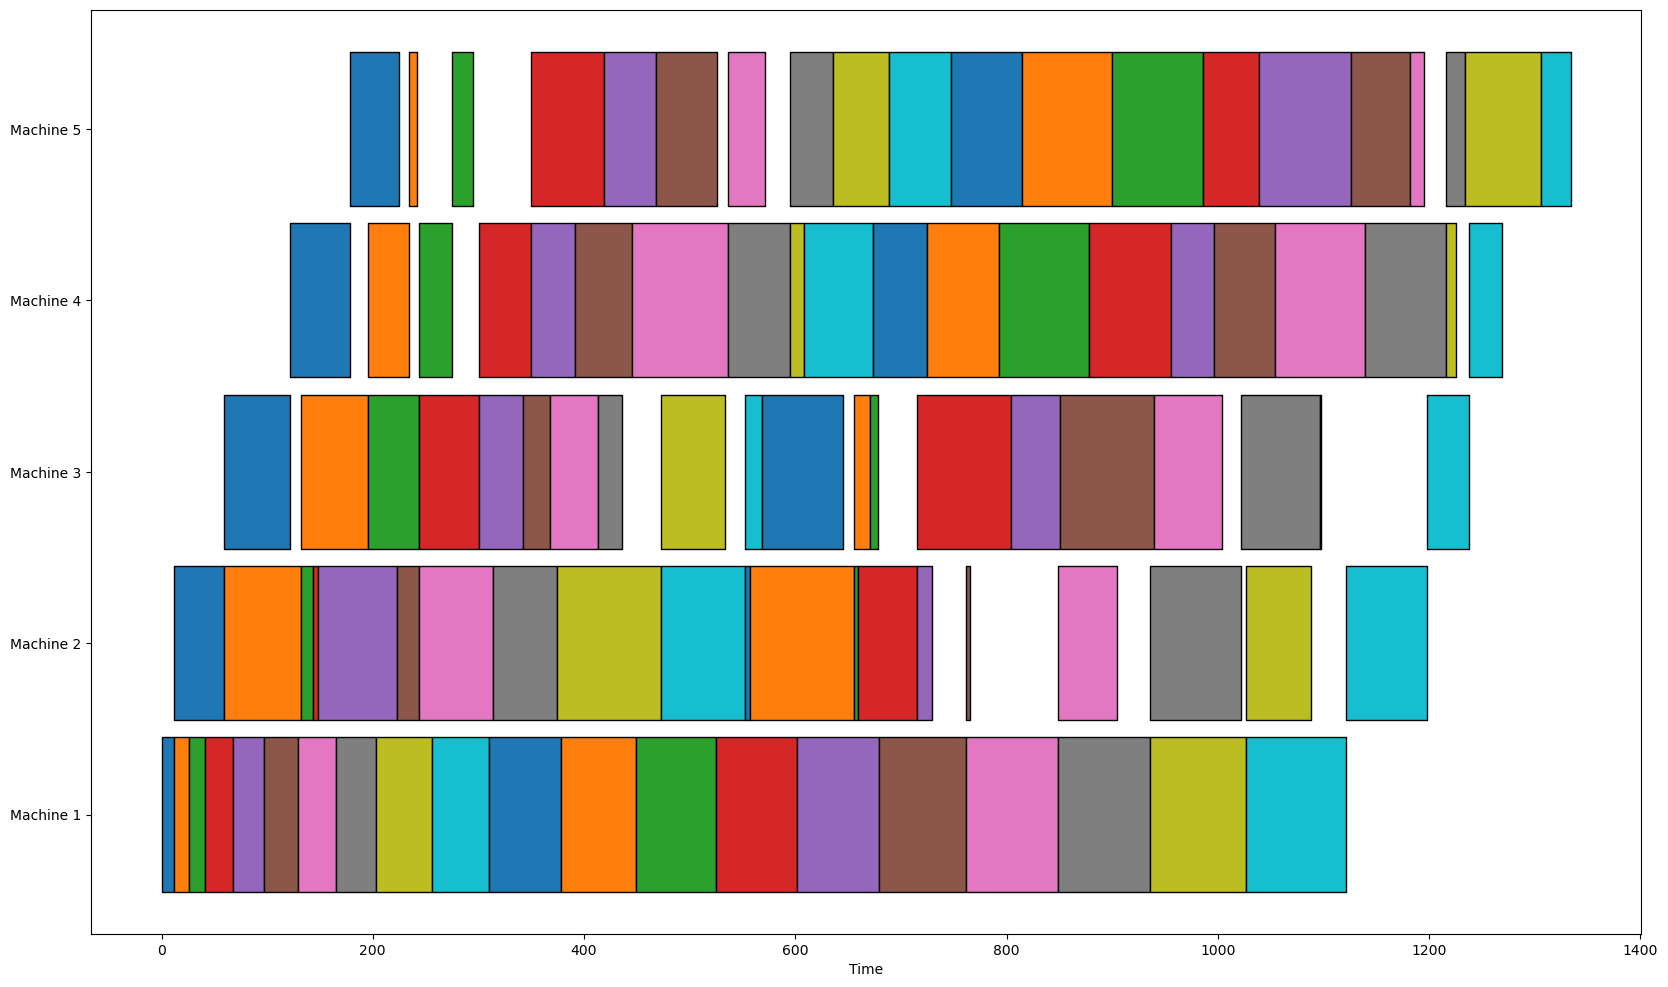

In [36]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Gupta Heuristic

In [37]:
def min_sum_processing(job_index, processing_times):
    min_sum = np.inf
    for i in range(processing_times.shape[1] - 1):
        sum_for_pair = processing_times[job_index,
                                        i] + processing_times[job_index, i + 1]
        if sum_for_pair < min_sum:
            min_sum = sum_for_pair
    return min_sum

In [38]:
def calculate_priority(job_index, processing_times):
    diff = float(processing_times[job_index, 0] -
                 processing_times[job_index, -1])
    sign = (diff > 0) - (diff < 0)
    return sign / min_sum_processing(job_index, processing_times)

In [39]:
def gupta_heuristic(processing_times):
    priorities = [calculate_priority(i, processing_times)
                  for i in range(processing_times.shape[0])]
    total_times = [np.sum(processing_times[i])
                   for i in range(processing_times.shape[0])]
    sequence = sorted(range(len(priorities)), key=lambda k: (priorities[k], total_times[k]))

    best_makespan = incremental_cost(processing_times.T,sequence)
    return sequence, best_makespan

### GUPTA TEST

In [40]:
start_time = time.time()

best_solution, best_cost  = gupta_heuristic(benchmarks[0])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of GUPTA:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of GUPTA:
Best sequence is [10, 2, 8, 16, 14, 15, 7, 13, 0, 3, 18, 6, 4, 5, 9, 17, 1, 19, 12, 11] 
 with a makespan of 1396.0.
Elapsed time of 0.004549741744995117 seconds.


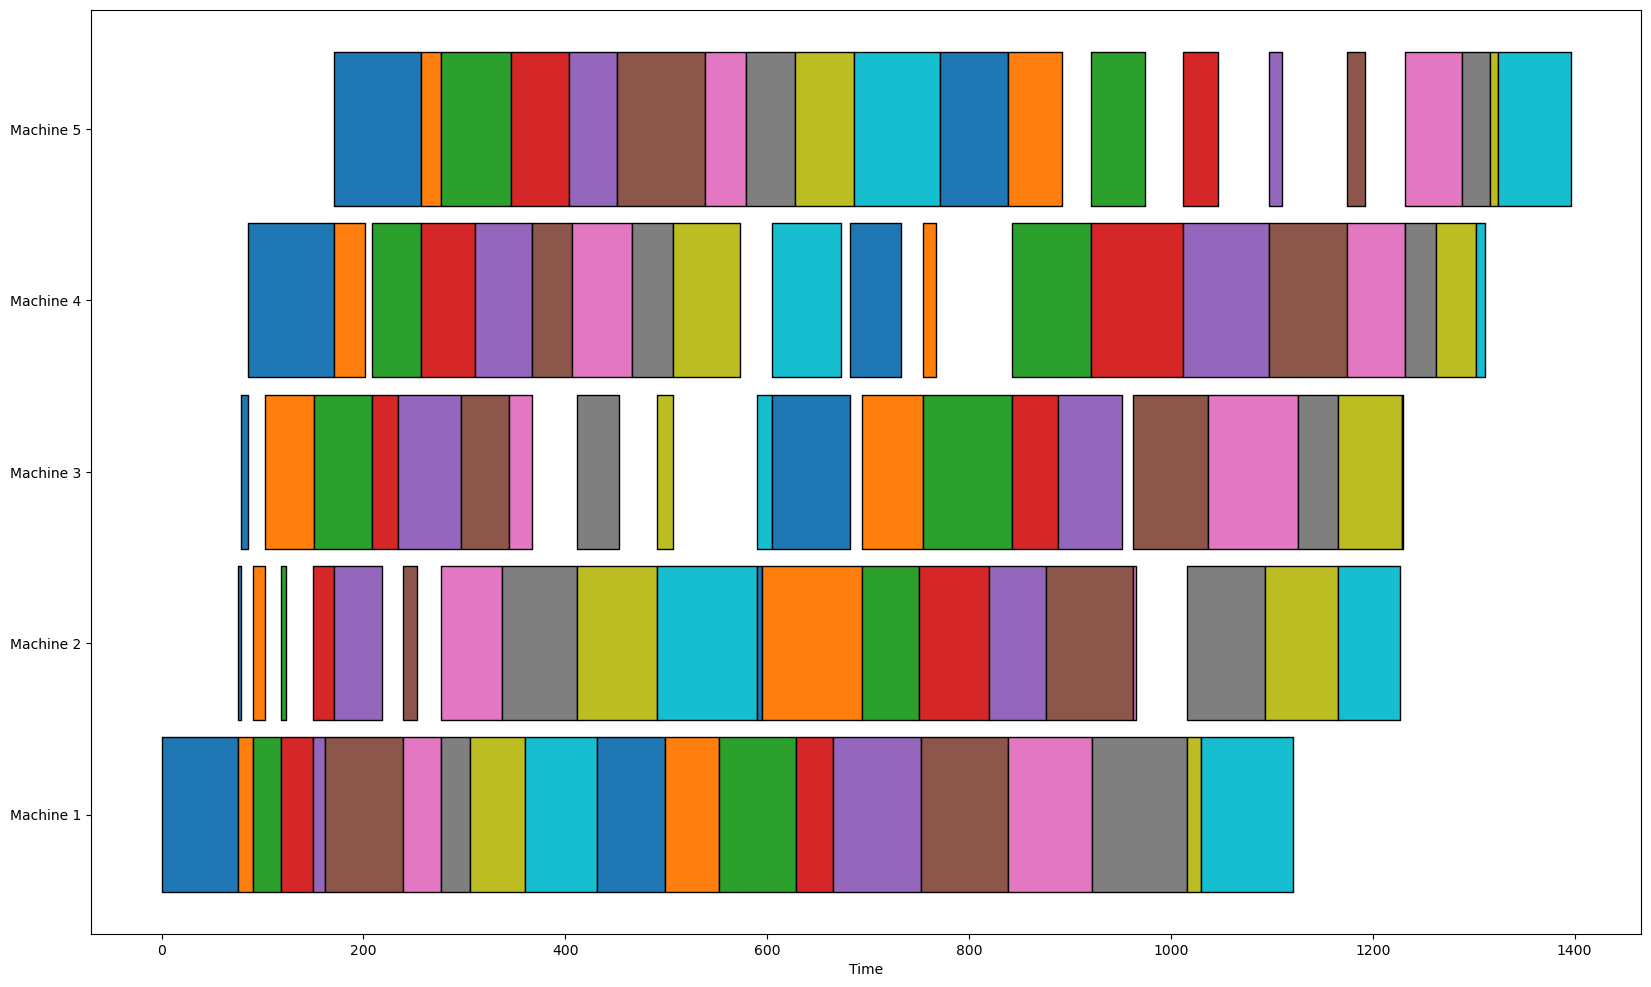

In [41]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## NRH Heuristic (NEW Ramzi Heuristic)

In [42]:
def new_heuristic(processing_times, shuffle_count=10):
    transformed = np.vectorize(lambda row, col: processing_times[row, col]/(np.exp(-col)))(*np.indices(processing_times.shape))
    
    # sum for each job (sum each row elements)
    transformed_sum = np.sum(transformed, axis=1)
    print(transformed_sum)
    transformed_reshaped = transformed_sum.reshape(-1)
    
    initial_order = list(sorted(range(processing_times.shape[0]), key=lambda x: transformed_reshaped[x], reverse=True))
    
    current_make_span = incremental_cost(processing_times.T, initial_order)
    current_order = initial_order
    
    for i in range(shuffle_count):
        copy = current_order.copy()

        random.shuffle(copy)
        cost = incremental_cost(processing_times.T, copy)
        if cost < current_make_span: 
            current_make_span = cost
            current_order = list(copy)

    maskepan = incremental_cost(benchmarks[0].T, current_order)

    return current_order, maskepan
    # we consider the different possible orders
    

### NRH TEST

In [43]:
start_time = time.time()

best_solution, best_cost = new_heuristic(benchmarks[0], shuffle_count=10)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of NRH:')
print(f'Best sequence is {best_solution} \n with a makespan of {best_cost}.')
print(f'Elapsed time of {elapsed_time} seconds.')

[4879.30730088 4971.23838169 2121.57949424 6457.6050061  5347.22360696
 4297.50636361 3920.26719871 3794.61602981 5213.2312683  3129.16996163
 6538.5897795  4376.04088233 1898.06624798 4034.63880267 4296.17289943
 6015.80211206 4532.51107274 3404.30448835 5387.5853141  2750.2697903 ]
Results of NRH:
Best sequence is [2, 16, 13, 18, 5, 4, 7, 1, 9, 6, 19, 11, 10, 14, 15, 12, 8, 3, 0, 17] 
 with a makespan of 1414.0.
Elapsed time of 0.004650115966796875 seconds.


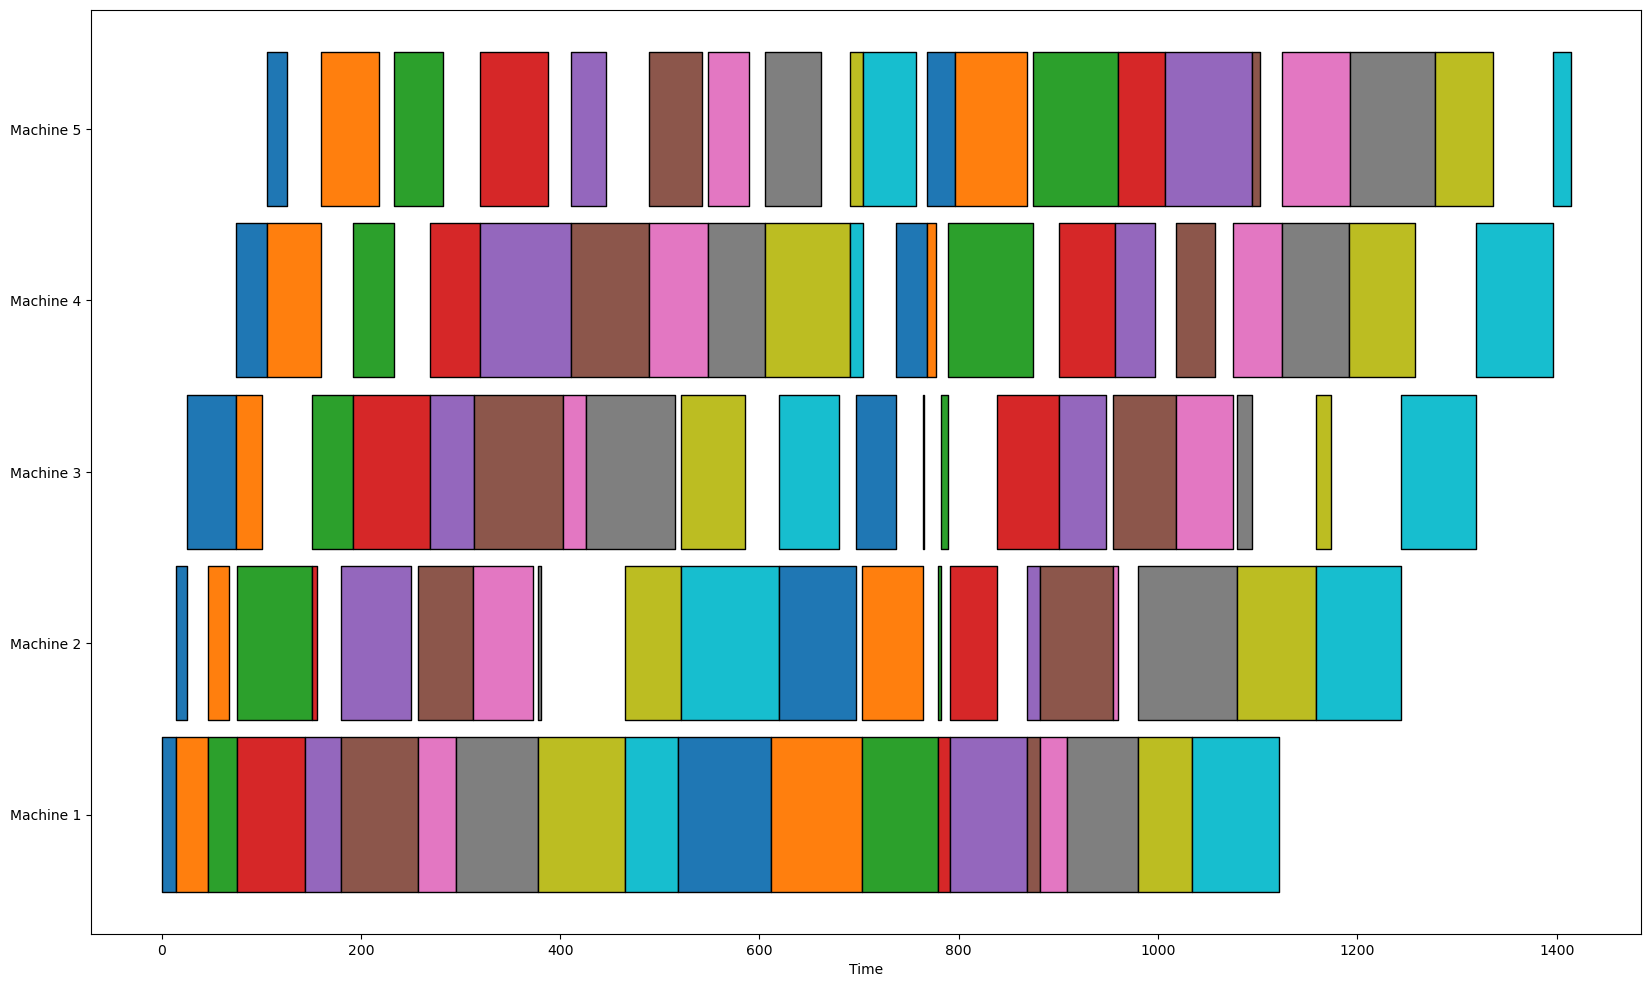

In [44]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Kusiak Heuristic

In [45]:
def kusiak(flowshop):
    """
    Kusiak algorithm for the flowshop scheduling problem.

    Parameters:
        flowshop (numpy.ndarray): Flowshop matrix where rows represent jobs and columns represent machines.

    Returns:
        numpy.ndarray: Sequence of jobs in the optimal order.
    """
    num_jobs, num_machines = flowshop.shape

    # Calculate initial completion times for each job on each machine
    completion_times = np.zeros((num_jobs, num_machines))
    for i in range(num_jobs):
        completion_times[i][0] = flowshop[i][0]
    for j in range(1, num_machines):
        completion_times[0][j] = completion_times[0][j-1] + flowshop[0][j]
    for i in range(1, num_jobs):
        for j in range(1, num_machines):
            completion_times[i][j] = max(completion_times[i-1][j], completion_times[i][j-1]) + flowshop[i][j]

    # Create a list of jobs
    jobs = list(range(num_jobs))

    # Sort jobs based on the total completion time across machines
    jobs.sort(key=lambda job: sum(completion_times[job, :]))

    # Convert the sorted job list to numpy array for easy indexing
    sorted_jobs = np.array(jobs)
    
    makespan = incremental_cost(flowshop.T,sorted_jobs)

    return sorted_jobs, makespan


### Kusiak Test

In [46]:
start_time = time.time()

best_sequence, makespan = kusiak(benchmarks[6])

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results of Kusiak:')
# print(f'Best sequence is {best_solution} \n with a makespan of {calculate_makespan(benchmarks[0], best_sequence)}.')
print(f'Best sequence is {best_sequence} \n with a makespan of {makespan}.')
print(f'Elapsed time of {elapsed_time} seconds.')

Results of Kusiak:
Best sequence is [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
 with a makespan of 1528.0.
Elapsed time of 0.002202749252319336 seconds.


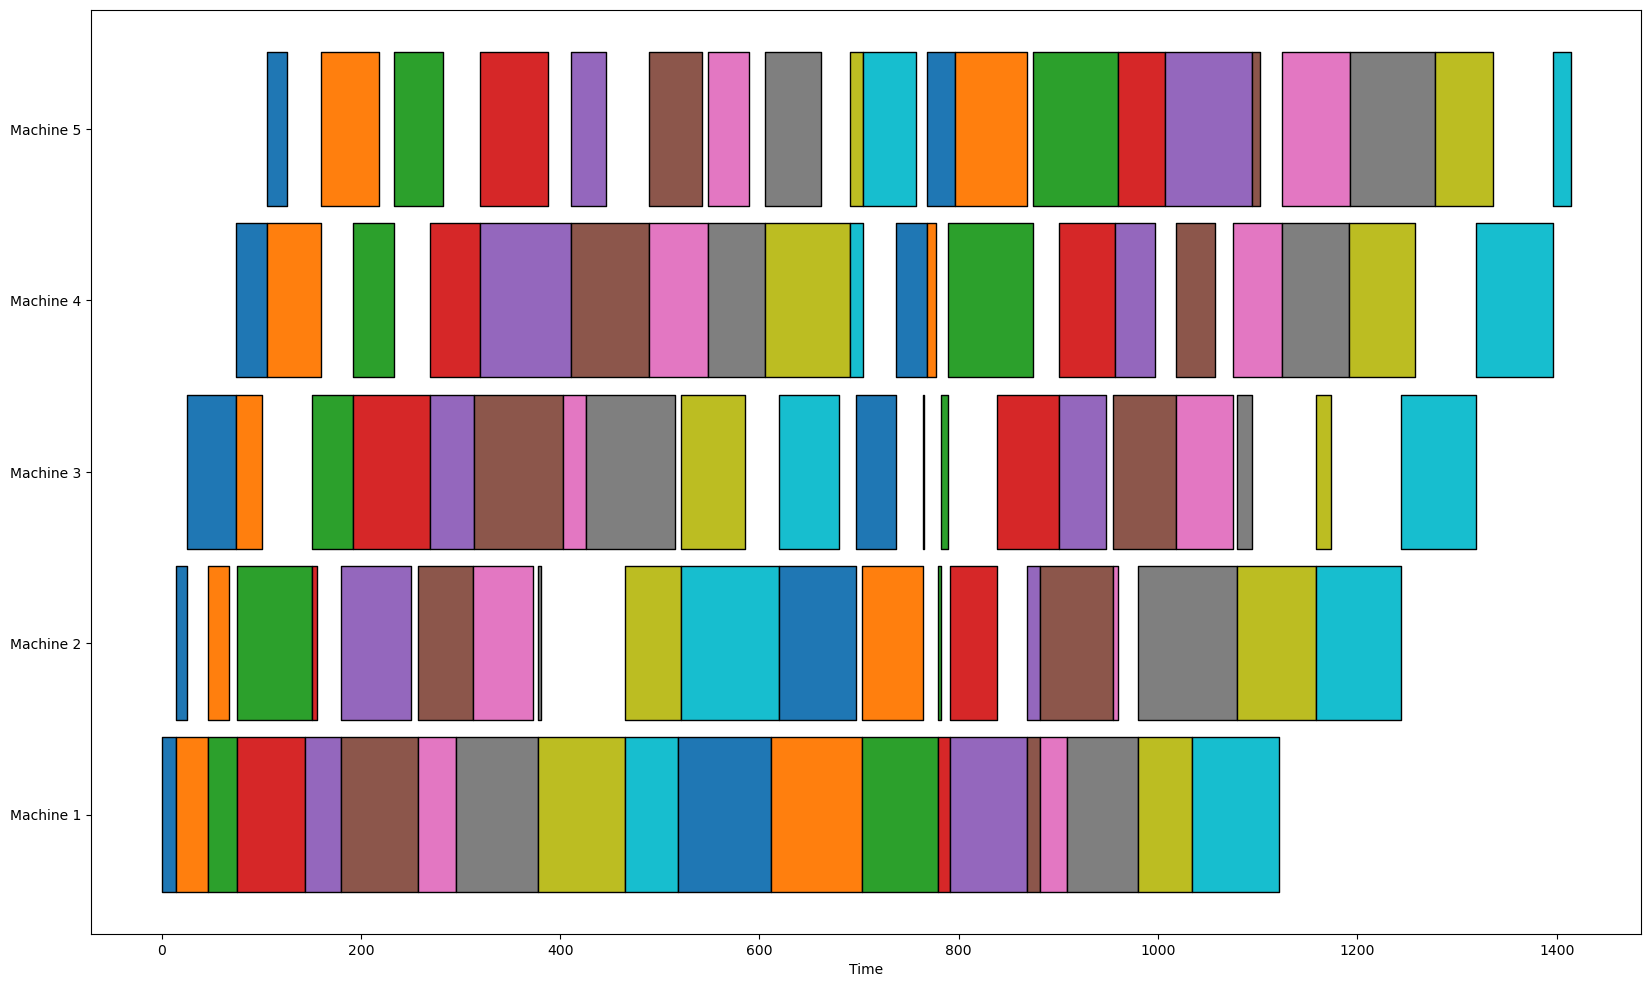

In [47]:
generate_gantt_chart(benchmarks[0].T,best_solution )

## Comparison Figure

In [69]:
def run_all_algo(processing_times, upper_bound):
    Palmer = PalmerHeuristic(processing_times.T)
    heuristics = []
    heuristics.append(('NEH', neh_algorithm(processing_times)))
    heuristics.append(('CDS', cds_heuristic(processing_times.T)))
    heuristics.append(('PRSKE', PRSKE(processing_times)))
    heuristics.append(('CHEN', chen_heuristic(processing_times)))
    heuristics.append(('NRH', new_heuristic(processing_times)))
    heuristics.append(('Weighted_CDS', Weighted_CDS_heuristic(processing_times)))
    heuristics.append(('GUPTA', gupta_heuristic(processing_times)))
    heuristics.append(('HAM', ham_heuristic(processing_times)))
    heuristics.append(('Palmer', Palmer.run()))
    heuristics.append(('Kusiak', kusiak(processing_times)))
    
    result = []
    for name, heuristic in heuristics:
        stat = []
        start_time = time.perf_counter()
        par1, par2 = heuristic
        end_time = time.perf_counter()
        elapsed_time = (end_time - start_time) * 1e6
        RDP = (( par2 - upper_bound )/ upper_bound ) * 100
        stat = (name, RDP, elapsed_time)
        result.append(stat)
        
    return result

In [70]:
def generate_histogram(tab_stats):

    RDP = [stat[1] for stat in tab_stats]
    Execution_time = [stat[2] for stat in tab_stats]

    fig, ax = plt.subplots(figsize=(18, 10))

    index = np.arange(len(tab_stats))
    bar_width = 0.35

    rects1 = ax.bar(index, RDP, bar_width,
                    color='#D9731A',
                    label='RDP')

    rects2 = ax.bar(index + bar_width, Execution_time, bar_width,
                    color='#2A2359',
                    label='Execution Time')

    ax.set_xlabel('Heuristics')
    ax.set_ylabel('RDP / Execution Time ')

    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([stat[0] for stat in tab_stats])

    ax.legend()
    plt.show()


[4879.30730088 4971.23838169 2121.57949424 6457.6050061  5347.22360696
 4297.50636361 3920.26719871 3794.61602981 5213.2312683  3129.16996163
 6538.5897795  4376.04088233 1898.06624798 4034.63880267 4296.17289943
 6015.80211206 4532.51107274 3404.30448835 5387.5853141  2750.2697903 ]


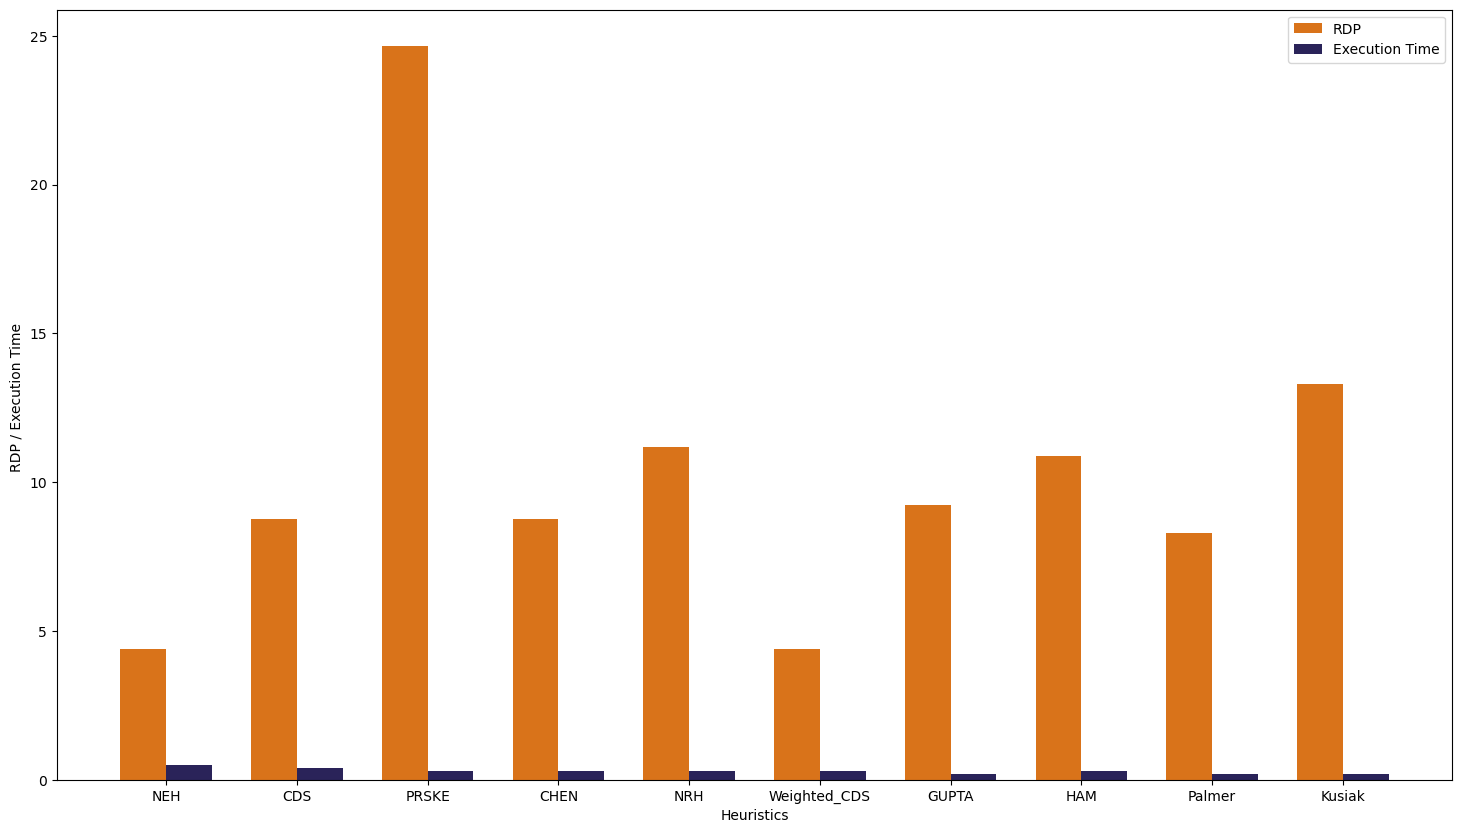

In [71]:
var = run_all_algo(benchmarks[0], upper_bound[0])
generate_histogram(var)